# Renko & OBV

In [1]:
import pandas_datareader.data as pdr
import pandas as pd
import numpy as np
import datetime
import copy
import sys
import warnings

from stocktrends import Renko
from itertools import product

warnings.simplefilter(action='ignore')
sys.path.append("../")

from data.make_dataset import get_stock_intraday
from technical_indicators import get_atr, get_obv, get_renko, get_slopes
from kpi import get_sharpe, get_cagr, get_max_drawdown, get_calmar

/anaconda3/envs/fx/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
tickers = ["MSFT","AAPL","FB","AMZN","INTC"]
ohlc_intraday = get_stock_intraday("alpha_vantage_key.txt", tickers)

MSFT
AAPL
FB
AMZN
INTC


In [4]:
ohlc_renko = {}
dfs = copy.deepcopy(ohlc_intraday)
for ticker in tickers:
    print(f"Get renko for:{ticker}")
    renko = get_renko(dfs[ticker])
    print(f"Merging for :{ticker}")
    dfs[ticker].reset_index(inplace=True)
    ohlc_renko[ticker] = dfs[ticker].merge(renko[['date', "trend"]], how='outer', on='date')
    ohlc_renko[ticker]['trend'].fillna(method='ffill', inplace=True)
    ohlc_renko[ticker]['obv'] = get_obv(ohlc_renko[ticker])
    ohlc_renko[ticker]['obv_slope'] = get_slopes(ohlc_renko[ticker]['obv'], 5, degree=True)

Get renko for:MSFT
Merging for :MSFT
Get renko for:AAPL
Merging for :AAPL
Get renko for:FB
Merging for :FB
Get renko for:AMZN
Merging for :AMZN
Get renko for:INTC
Merging for :INTC


In [46]:
def buy_signal(df, i, renko_nb=2, slope_degree=30):
    return df['trend'][i] >= renko_nb and df['obv_slope'][i] > slope_degree


def sell_signal(df, i, renko_nb=2, slope_degree=30):
    return df['trend'][i] <= -renko_nb and df['obv_slope'][i] <= slope_degree


def no_signal(df, i, renko_nb=2):
    return df['trend'][i] < 2


def get_returns(df, i):
    return (df['Adj Close'][i]/df['Adj Close'][i-1])-1


def backtest(ohlc_renko, renko_nb, slope_degree, verbose=False):
    """Backtest the Renko & OBV."""
    # Setup
    tickers = list(ohlc_renko.keys())
    ticker_signal = {ticker: None for ticker in tickers}
    ticker_return = {ticker: [] for ticker in tickers}
    # Compute returns for each ticker
    for ticker in tickers:
        if verbose:
            print(f"Calculating daily returns for: {ticker}")
        try:
            del df
        except NameError:
            pass
        finally: 
            df = ohlc_renko[ticker].reset_index()
        for i, _ in df.iterrows():
            if ticker_signal[ticker] is None or ticker_signal[ticker] == 0:
                ticker_return[ticker].append(0)
                if buy_signal(df, i, renko_nb, slope_degree):
                    ticker_signal[ticker] = 1
                elif sell_signal(df, i, renko_nb, slope_degree):
                    ticker_signal[ticker] = -1

            elif ticker_signal[ticker] == 1:
                ticker_return[ticker].append(get_returns(df, i))
                if sell_signal(df, i, renko_nb, slope_degree):
                    ticker_signal[ticker] = -1
                elif no_signal(df, i):
                    ticker_signal[ticker] = 0

            elif ticker_signal[ticker] == -1:
                ticker_return[ticker].append(get_returns(df, i))
                if buy_signal(df, i, renko_nb, slope_degree):
                    ticker_signal[ticker] = 1
                elif no_signal(df, i):
                    ticker_signal[ticker] = 0
        ohlc_renko[ticker]['returns'] = ticker_return[ticker]
    returns_df = pd.DataFrame({ticker: ohlc_renko[ticker]['returns'] for ticker in tickers})
    returns_df['total_returns'] = returns_df.sum(axis=1)
    return returns_df

In [47]:
params = {'renko_nb':[1, 2, 3, 4, 5], 'slope':[25, 30, 35, 40, 45, 85]}
results = {}

In [48]:
for r, s in product(params['renko_nb'], params['slope']):
    print(f"Strategy: renko_nb={r} and slope={s}")
    results[f'r: {r} & s: {s}'] = backtest(ohlc_renko, renko_nb=r, slope_degree=s)

Strategy: renko_nb=1 and slope=25
Strategy: renko_nb=1 and slope=30
Strategy: renko_nb=1 and slope=35
Strategy: renko_nb=1 and slope=40
Strategy: renko_nb=1 and slope=45
Strategy: renko_nb=1 and slope=85
Strategy: renko_nb=2 and slope=25
Strategy: renko_nb=2 and slope=30
Strategy: renko_nb=2 and slope=35
Strategy: renko_nb=2 and slope=40
Strategy: renko_nb=2 and slope=45
Strategy: renko_nb=2 and slope=85
Strategy: renko_nb=3 and slope=25
Strategy: renko_nb=3 and slope=30
Strategy: renko_nb=3 and slope=35
Strategy: renko_nb=3 and slope=40
Strategy: renko_nb=3 and slope=45
Strategy: renko_nb=3 and slope=85
Strategy: renko_nb=4 and slope=25
Strategy: renko_nb=4 and slope=30
Strategy: renko_nb=4 and slope=35
Strategy: renko_nb=4 and slope=40
Strategy: renko_nb=4 and slope=45
Strategy: renko_nb=4 and slope=85
Strategy: renko_nb=5 and slope=25
Strategy: renko_nb=5 and slope=30
Strategy: renko_nb=5 and slope=35
Strategy: renko_nb=5 and slope=40
Strategy: renko_nb=5 and slope=45
Strategy: renk

In [49]:
final_results = {}
for strategy in results.keys():
    final_results[strategy] = results[strategy]['total_returns'].sum()

## Calculating Strategy KPIs

In [50]:
cagr = {}
sharpe = {}
max_dd = {}
calmar = {}
for strategy in results.keys():
    print("Calculating KPIs for: ", strategy)
    cagr[strategy] = get_cagr(results[strategy], 'total_returns', 252*78)
    sharpe[strategy] = get_sharpe(results[strategy], 'total_returns', 0.0225, 252*78)
    max_dd[strategy] = get_max_drawdown(results[strategy], 'total_returns')
    calmar[strategy] = get_calmar(results[strategy], 'total_returns', annualized_const=0.0225)

Calculating KPIs for:  r: 1 & s: 25
Calculating KPIs for:  r: 1 & s: 30
Calculating KPIs for:  r: 1 & s: 35
Calculating KPIs for:  r: 1 & s: 40
Calculating KPIs for:  r: 1 & s: 45
Calculating KPIs for:  r: 1 & s: 85
Calculating KPIs for:  r: 2 & s: 25
Calculating KPIs for:  r: 2 & s: 30
Calculating KPIs for:  r: 2 & s: 35
Calculating KPIs for:  r: 2 & s: 40
Calculating KPIs for:  r: 2 & s: 45
Calculating KPIs for:  r: 2 & s: 85
Calculating KPIs for:  r: 3 & s: 25
Calculating KPIs for:  r: 3 & s: 30
Calculating KPIs for:  r: 3 & s: 35
Calculating KPIs for:  r: 3 & s: 40
Calculating KPIs for:  r: 3 & s: 45
Calculating KPIs for:  r: 3 & s: 85
Calculating KPIs for:  r: 4 & s: 25
Calculating KPIs for:  r: 4 & s: 30
Calculating KPIs for:  r: 4 & s: 35
Calculating KPIs for:  r: 4 & s: 40
Calculating KPIs for:  r: 4 & s: 45
Calculating KPIs for:  r: 4 & s: 85
Calculating KPIs for:  r: 5 & s: 25
Calculating KPIs for:  r: 5 & s: 30
Calculating KPIs for:  r: 5 & s: 35
Calculating KPIs for:  r: 5 

In [51]:
kpi_df = pd.DataFrame([cagr, sharpe, max_dd, calmar], index=['cagr', 'sharpe', 'max_dd', 'calmar']).T

In [52]:
kpi_df.sort_values('sharpe', ascending=False)

,cagr,sharpe,max_dd,calmar
r: 2 & s: 25,109801.689,85380.709,0.193,0.0
r: 1 & s: 25,95448.532,69947.558,0.212,0.0
r: 2 & s: 30,76378.414,59569.233,0.194,0.0
r: 1 & s: 40,70417.434,58599.421,0.137,0.0
r: 1 & s: 30,68264.461,50108.345,0.214,0.0
r: 2 & s: 35,62042.530,49134.142,0.195,0.0
r: 2 & s: 40,33040.852,28552.153,0.132,0.0
r: 1 & s: 35,31716.941,23514.226,0.209,0.0
r: 3 & s: 25,19701.548,17771.394,0.141,0.0
r: 3 & s: 30,13939.602,12613.246,0.131,0.0


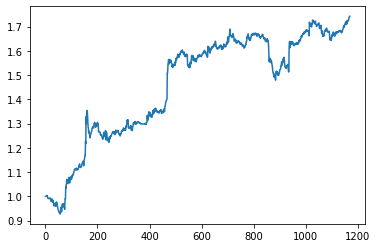

In [53]:
(1 + results['r: 2 & s: 25']['total_returns'].cumsum()).plot()